In [ ]:
import struct
import numpy as np

In [27]:
np.set_printoptions(precision=1)

In [4]:
train_img = 'C:/Users/pchavan/The Bridge/MLStuff/ANN_Practice/Kaggle_MNIST/train-images.idx3-ubyte'
train_lbl = 'C:/Users/pchavan/The Bridge/MLStuff/ANN_Practice/Kaggle_MNIST/train-labels.idx1-ubyte'
test_img = 'C:/Users/pchavan/The Bridge/MLStuff/ANN_Practice/Kaggle_MNIST/t10k-images.idx3-ubyte'
test_lbl = 'C:/Users/pchavan/The Bridge/MLStuff/ANN_Practice/Kaggle_MNIST/t10k-labels.idx1-ubyte'

In [5]:
def read_idx3_ubtype(filename):
    with open(filename, 'rb') as f:
        #The MNIST File content is big-endian unsigned int (>I)
        magic, = struct.unpack('>I', f.read(4))

        #0x00000803(2051) is for image file
        if magic == 2051:
            n_images, n_rows, n_cols = struct.unpack('>III', f.read(12))
            return np.fromfile(f, dtype=np.uint8).reshape(n_images, n_rows * n_cols) 
        else:
            n_lables, = struct.unpack('>I', f.read(4))
            return np.fromfile(f, dtype=np.uint8).reshape(n_lables, 1)

In [6]:
train_data = read_idx3_ubtype(train_img)
train_labels = read_idx3_ubtype(train_lbl)
test_data = read_idx3_ubtype(test_img)
test_labels = read_idx3_ubtype(test_lbl)

In [7]:
train_labels[8197]

array([8], dtype=uint8)

In [8]:
#Vectorize lables
def vectorize(i):
    out = np.zeros((10,1))
    out[i] = 1
    return out

vectorize(train_labels[8197])

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.]])

In [9]:
np.set_printoptions(linewidth=200)
train_data[8197].reshape(28, 28)

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6, 196, 255, 229,  66,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  64, 253, 254, 253, 251, 104,   0

In [10]:
#normaliez 
# Convert to float64 and wrap
vec_train_labels = np.array([vectorize(l) for l in train_labels])
vec_test_labels = np.array([vectorize(l) for l in test_labels])
train_data = [(np.reshape(img, (784, 1)), lbl) for img, lbl in zip(train_data.astype(np.float64) / 255.0, vec_train_labels)]
test_data = [(np.reshape(img, (784, 1)), lbl) for img, lbl in zip(test_data.astype(np.float64) / 255.0, vec_test_labels)]

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

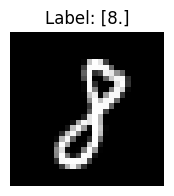

In [12]:
# Visualize a single image
plt.figure(figsize=(2,2))
image = train_data[8197][0].reshape(28, 28)
label = np.dot(range(10), train_data[8197][1])
plt.imshow(image, cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

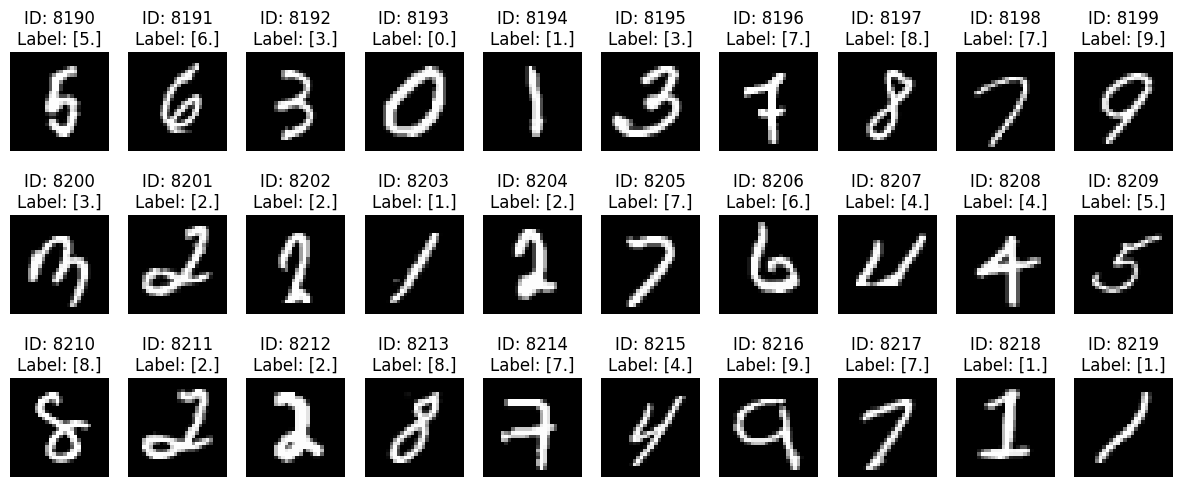

In [13]:
# Visualize a multiple images
def show_images(idx):
    n_plots = len(idx)
    n_cols = 10
    n_rows = np.max([1, int(n_plots / 10)])
    plt.figure(figsize=(15, n_rows*2))
    for i in range(len(idx)):
        plt.subplot(n_rows, n_cols, i + 1)
        image = train_data[idx[i]][0].reshape(28, 28)
        label = np.dot(range(10), train_data[idx[i]][1])
        plt.imshow(image, cmap='gray')
        plt.title(f"ID: {idx[i]}\nLabel: {label}")
        plt.axis('off')
    plt.show()

show_images(range(8190,8220, 1))

In [14]:
import random
import numpy as np

class Network(object):

    def __init__(self, sizes):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, learning_rate,
            test_data=None):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs."""
        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, learning_rate)
            if test_data and j % 2 == 0:
                print (f"Epoch {j}: {self.evaluate(test_data)} / {n_test}")
            else:
                print (f"Epoch {j} complete")

    def update_mini_batch(self, mini_batch, learning_rate):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch."""
        del_b = [np.zeros(b.shape) for b in self.biases]
        del_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_del_b, delta_del_w = self.backprop(x, y)
            del_b = [dohb + d_dohb for dohb, d_dohb in zip(delta_del_b, del_b)]
            del_w = [dohw + d_dohw for dohw, d_dohw in zip(delta_del_w, del_w)]
        self.weights = [w-(learning_rate/len(mini_batch)) * dohw
                        for w, dohw in zip(self.weights, del_w)]
        self.biases = [b-(learning_rate/len(mini_batch))* dohb
                       for b, dohb in zip(self.biases, del_b)]

    def backprop(self, x, y):
        """Return a tuple ``(del_b, del_w)`` representing the
        gradient for the cost function C_x.  ``del_b`` and
        ``del_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        del_b = [np.zeros(b.shape) for b in self.biases]
        del_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = (activations[-1] - y) * sigmoid_prime(zs[-1])   #activations[-1] - y is output layer cost
        del_b[-1] = delta
        del_w[-1] = np.dot(delta, activations[-2].transpose())
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            # if l == 1: continue 
            # else: 
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            del_b[-l] = delta
            del_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (del_b, del_w)

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result"""
        test_results = [(np.argmax(self.feedforward(x)), np.argmax(y)) for (x, y) in test_data]
        return np.sum(int(x == y) for (x, y) in test_results)

# Misc functions
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

In [15]:
net = Network([784, 30, 10])

In [16]:
net.SGD(train_data, 10, 30, 3.0, test_data=test_data)

C:\Users\pchavan\AppData\Local\Temp\ipykernel_37164\2964471416.py:89: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(int(x == y) for (x, y) in test_results)


Epoch 0: 8038 / 10000
Epoch 1 complete
Epoch 2: 9186 / 10000
Epoch 3 complete
Epoch 4: 9293 / 10000
Epoch 5 complete
Epoch 6: 9365 / 10000
Epoch 7 complete
Epoch 8: 9407 / 10000
Epoch 9 complete


In [17]:
net.evaluate(test_data)

C:\Users\pchavan\AppData\Local\Temp\ipykernel_37164\2964471416.py:89: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(int(x == y) for (x, y) in test_results)


9413

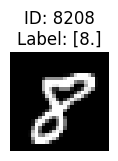

In [18]:
show_images([8208])

In [28]:
net.feedforward(train_data[8208][0])

array([[3.2e-04],
       [4.6e-04],
       [7.5e-04],
       [2.0e-03],
       [1.7e-03],
       [2.7e-04],
       [1.1e-04],
       [2.6e-05],
       [9.9e-01],
       [5.3e-02]])

In [29]:
train_data[8208][0].reshape(28, 28)

array([[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0.3, 0.8, 1. 

In [30]:
test_results = [(np.argmax(net.feedforward(x)), np.argmax(y)) for (x, y) in test_data]
incorrect = []
counter = 0
for (x, y) in test_results:
    counter += 1
    if int(x != y):
        incorrect.append((counter, x, y))

In [49]:
# Visualize a multiple images
def incorrect_gusses(idx):
    n_plots = len(idx)
    n_cols = 10
    n_rows = np.max([1, int(n_plots / 10)])
    plt.figure(figsize=(15, n_rows*2))
    for i in range(len(idx)):
        plt.subplot(n_rows, n_cols, i + 1)
        image = test_data[idx[i][0]][0].reshape(28, 28)
        label = np.dot(range(10), test_data[idx[i][1]][1])
        plt.imshow(image, cmap='gray')
        plt.title(f"ID: {idx[i]}\nLabel: {label}")
        plt.axis('off')
    plt.show()

In [61]:
for i in range(len(incorrect[0:10])):
    print(np.dot(range(10), test_data[incorrect[i][0]][1]))

[7.]
[1.]
[9.]
[9.]
[9.]
[1.]
[0.]
[4.]
[8.]
[1.]


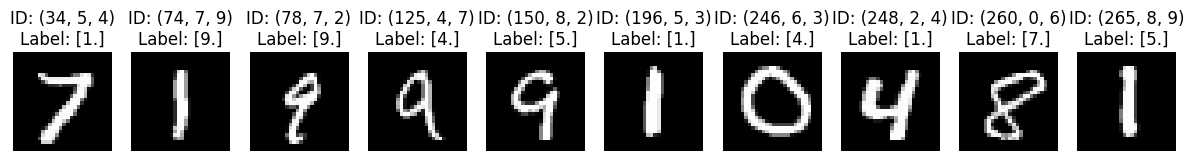

In [51]:
incorrect_gusses(incorrect[0:10])

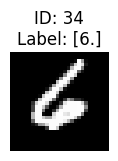

In [52]:
show_images([34])